In [1]:
import sys
import os
from os import listdir
from os.path import isfile, join, expanduser
home = expanduser("~")
sys.path.append(join(home,'Projects/helpfullscripts/'))
sys.path.append(join(home,'Projects/'))
sys.path.append(join(home,'Projects/XRR_workflows/calculate_n_k_from_xrr/'))
sys.path.append(home)
sys.path.append('../')
#sys.path.append(r'C:\Users\Kas\Documents\GitHub')
#sys.path.append(r'C:\Users\Kas\Documents\GitHub\XRR_workflows\calculate_n_k_from_xrr')
import matrixmethod.mm_numba as mm
import numpy as np
import matplotlib.pyplot as plt
import xray_compounds as xc
import pandas as pd
import pint
unit = pint.UnitRegistry()
import scipy
import pickle 
import emcee
import tqdm
from multiprocessing import Pool
from scipy.optimize import differential_evolution
from scipy.ndimage import gaussian_filter1d
import scipy.interpolate as si

In [2]:
c = scipy.constants.c #speed of light
h = scipy.constants.h #Planck
e = scipy.constants.e #elemetry charge
hc = h*c/e*1e9 #wavelenght in nm
print(hc)
def eVnm_converter(value):
    #Planck's constant (6.6261 x 10-34 J*s) and c is the speed of light (2.9979 x 108 m/s)
    return hc/value

1239.8419843320025


In [3]:
def make_b_spline_line_1(x, y, k=3, per=1, n=100):
    """
    x = np.array of x values
    y = np.array of y values
    len(x) = len(y)
    number of points interpolated for x_i, y_i
    """
    # make b splines
    y_tup = si.splrep(x, y, k=k, per=per)

    x_i = np.linspace(np.min(x), np.max(x), n)
    y_i = si.splev(x_i, y_tup)

    return x_i, y_i

In [4]:
def calc_layer(energy,aoi,thickness,delta, beta,roughness = 0):
    """
    energy in eV
    aoi in deg
    thickness in nm
    roughness in nm
    delta same shape as energy
    beta same shape as energy
    """
    T = []
    for i,E in enumerate(energy):
        delta_E = delta[i]
        beta_E = beta[i]
        aoi_rad = np.deg2rad(aoi)
        wl = eVnm_converter(E)
        layer = np.array([thickness])
        rough = np.array([roughness,roughness])
        n = np.array([1 + 0 * 1j, 1-delta_E + beta_E * 1j,1 + 0 * 1j])
        rm, tm = mm.reflec_and_trans(n, wl, aoi_rad, layer, rough, pol=0)  # polarization (either 1 for s-polarization or 0 for p-polarization)
        tm = np.square(np.abs(np.asarray(tm)))
        T.append(tm[0])

    return np.asarray(T[0])
    

In [5]:
def calc_box(m,energy,a,d,z,delta,beta,M=1000):
    """
    energy in eV
    m orders
    M number of grating lines
    a width of grating in nm
    d pitch of grating in nm
    z thickness of grating in nm
    delta same shape as energy
    beta same shape as energy
    """
    q = 2*np.pi/eVnm_converter(energy)
    a_d = a/d
    T_m = np.zeros((len(m)))
    for i,entry in enumerate(m):
        if entry == 0:
            T = np.square(a_d) + np.square(1-a_d)*np.exp(-2*q*z*beta) + 2*a_d*(1-a_d)*np.exp(-q*z*beta)*np.cos(q*z*delta)
        else:      
            m_pi = entry * np.pi
            T= np.square(np.sin(M*m_pi)/(M*np.sin(m_pi))) * np.square(np.sin(a_d*m_pi)/m_pi) * (1+np.exp(-2*q*z*beta)-2*np.exp(-q*z*beta)*np.cos(q*z*delta))
        #print(T)
        T_m[i] = T
    return T_m#.flatten()

def calc_box_1(m,energy,a,d,z,delta,beta):
    """
    energy in eV
    m orders
    M number of grating lines
    a width of grating in nm
    d pitch of grating in nm
    z thickness of grating in nm
    delta same shape as energy
    beta same shape as energy
    """
    q = 2*np.pi/eVnm_converter(energy)
    a_d = a/d
    T_m = np.zeros((len(m)))
    for i,entry in enumerate(m):
        if entry == 0:
            T = np.square(a_d) + np.square(1-a_d)*np.exp(-2*q*z*beta) + 2*a_d*(1-a_d)*np.exp(-q*z*beta)*np.cos(q*z*delta)
        else:      
            m_pi = entry * np.pi
            T= np.square(np.sin(a_d*m_pi)/m_pi) * (1+np.exp(-2*q*z*beta)-2*np.exp(-q*z*beta)*np.cos(q*z*delta))
        #print(T)
        T_m[i] = T
    return T_m#.flatten()

In [6]:
def brillance(I0,effeincy, N, d, wl, a, theta):
    theta = np.deg2rad(theta)
    beta = np.pi*d*np.sin(theta)/wl
    alpha = np.pi*a*np.sin(theta)/wl
    return I0 * effeincy * np.square(np.sin(N*beta)/N/np.sin(beta)) * np.square(np.sin(alpha)/alpha)

In [7]:
def multiplt_slits(I0,N,d, wl, a, theta):
    theta = np.deg2rad(theta)
    beta = np.pi*d*np.sin(theta)/wl
    alpha = np.pi*a*np.sin(theta)/wl
    return I0 * np.square(np.sin(N*beta)/np.sin(beta)) * np.square(np.sin(alpha)/alpha)


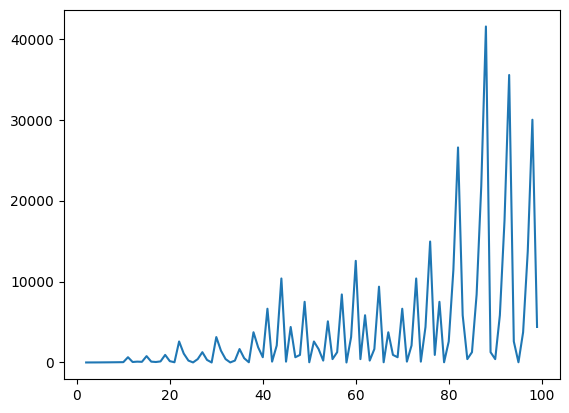

In [8]:
I0 = 1
effeincy = 1
d = 200
wl = 100
a = 50
theta = 90
N = np.arange(2,100,1)
plt.plot(N,multiplt_slits(I0, N, d, wl, a, theta))

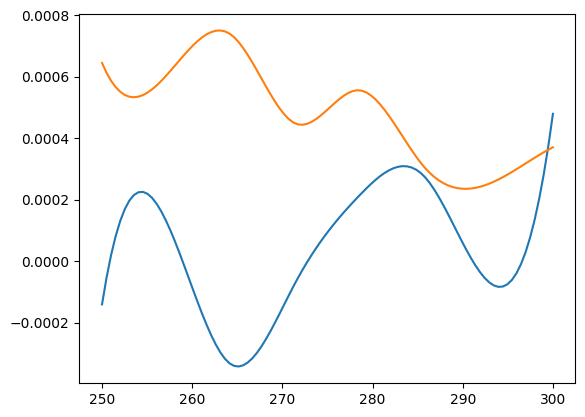

In [9]:
aoi = np.array([90])
n_energy = 100
energy = np.linspace(250,300,n_energy)
m = np.array([0,1,2,3,4])
pitch = 100
a = 50
thickness = 30
M=1000


# Define knot vector and control points
knots = np.linspace(250, 300, 8)
control_points = np.random.rand(len(knots) )
x,delta = make_b_spline_line_1(knots,control_points,per=0,n=n_energy)
delta = (delta-0.5)*1e-3
knots = np.linspace(250, 300, 8)
control_points = np.random.rand(len(knots) )
x,beta = make_b_spline_line_1(knots,control_points,per=0,n=n_energy)
beta = (beta)*1e-3


plt.plot(energy,delta)
plt.plot(energy,beta)



In [10]:
def sin_fun(x,M):
    return np.square(np.sin(x*M)/(M*np.sin(x)))

def sin_fun_1(x,M):
    return np.square(np.sin(x*M)/(np.sin(x)))

In [11]:
from scipy.integrate import quad
def integrand_2(x):
    return sin_fun_1(x, 100)  

def integrand_50(x):
    return sin_fun_1(x, 1000) 

a = 0*np.pi  # lower limit of integration
b = 0.5*np.pi  # upper limit of integration

result, error = quad(integrand_2, a, b)
print(f"The integral of the function from {a} to {b} is {result}")
print(f"The estimated error is {error}")

result, error = quad(integrand_50, a, b)
print(f"The integral of the function from {a} to {b} is {result}")
print(f"The estimated error is {error}")

The integral of the function from 0.0 to 1.5707963267948966 is 157.07963267948975
The estimated error is 9.896830295444853e-07
The integral of the function from 0.0 to 1.5707963267948966 is 1570.7988302784713
The estimated error is 2.4458266948505347


/tmp/ipykernel_386304/2928465141.py:15: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result, error = quad(integrand_50, a, b)


/tmp/ipykernel_386304/1655539937.py:5: RuntimeWarning: invalid value encountered in divide
  return np.square(np.sin(x*M)/(np.sin(x)))


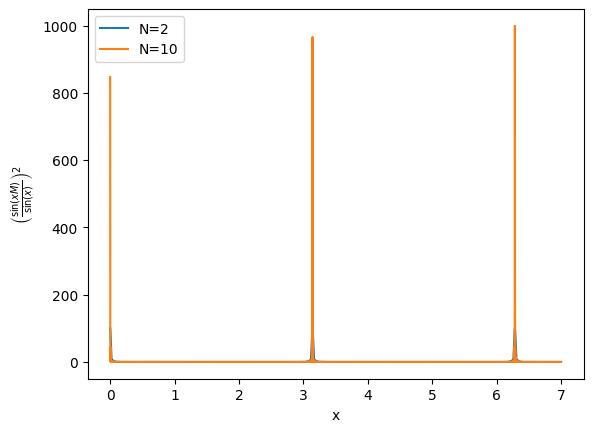

/tmp/ipykernel_386304/1655539937.py:2: RuntimeWarning: invalid value encountered in divide
  return np.square(np.sin(x*M)/(M*np.sin(x)))


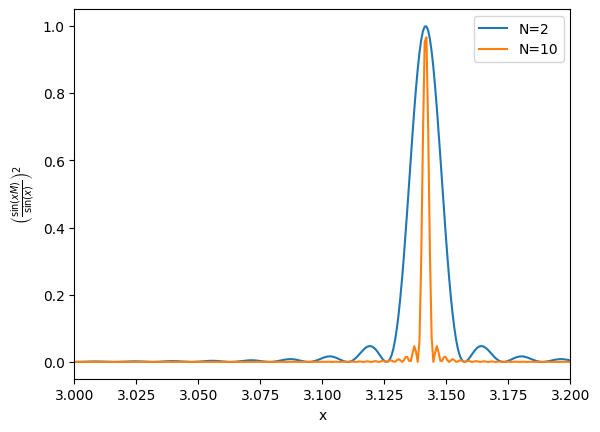

In [12]:

x = np.linspace(0,7,10000)
#plt.plot(x,sin_fun(x,2))
#plt.plot(x,sin_fun(x,100))

plt.plot(x,sin_fun_1(x,100)/100,label='N=2')
plt.plot(x,sin_fun_1(x,1000)/1000,label='N=10')
plt.xlabel('x')
plt.ylabel(r'$\left(\frac{\sin(xM)}{\sin(x)}\right)^2$')
plt.legend()
#plt.xlim(1,5)
#plt.yscale('log')
plt.show()



plt.plot(x,sin_fun(x,200),label='N=2')
plt.plot(x,sin_fun(x,1000),label='N=10')
plt.xlabel('x')
plt.ylabel(r'$\left(\frac{\sin(xM)}{\sin(x)}\right)^2$')
plt.xlim(3,3.2)
plt.legend()

Text(0, 0.5, 'Intensity')

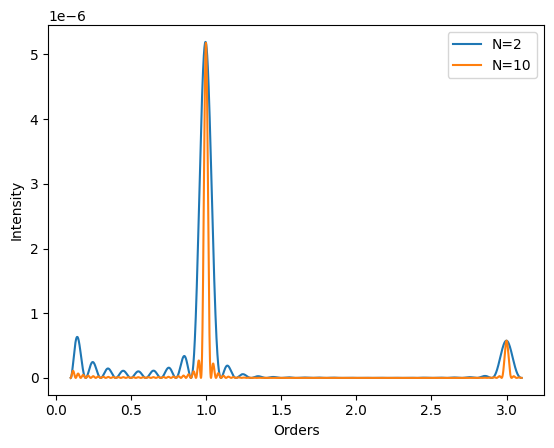

In [27]:
energy = 100
beta = 1e-3
delta = -1e-3
#T_layer = calc_layer([energy],aoi,thickness,[delta], [beta])
a =50
pitch = 100
thickness = 10
x = np.linspace(0.1,3.1,10000)
#T_Grating = calc_box(x,energy,a,pitch,thickness,delta,beta)
T_Grating_10 = calc_box(x,energy,a,pitch,thickness,delta,beta,M=10)
T_Grating_100 = calc_box(x,energy,a,pitch,thickness,delta,beta,M=30)
#plt.plot(energy,T_layer)
#print(np.sum(T_Grating))
plt.plot(x,T_Grating_10,label='N=2')
plt.plot(x,T_Grating_100,label='N=10')
plt.legend()
plt.xlabel('Orders')
plt.ylabel('Intensity')
#plt.yscale('log')
#plt.xlim(0.975,1.025)

In [55]:
def integrand_2(x):
    energy = 100
    beta = 1e-3
    delta = 1e-3
    #T_layer = calc_layer([energy],aoi,thickness,[delta], [beta])
    a =60
    pitch = 100
    thickness = 10
    return calc_box(x,energy,a,pitch,thickness,delta,beta,M=100)*100
def integrand_50(x):
    energy = 100
    beta = 1e-3
    delta = 1e-3
    #T_layer = calc_layer([energy],aoi,thickness,[delta], [beta])
    a =60
    pitch = 100
    thickness = 10
    return calc_box(x,energy,a,pitch,thickness,delta,beta,M=1000)*1000

a = 0.9  # lower limit of integration
b = 1.1  # upper limit of integration

result, error = quad(integrand_2, a, b)
print(f"The integral of the function from {a} to {b} is {result}")
print(f"The estimated error is {error}")

result, error = quad(integrand_50, a, b)
print(f"The integral of the function from {a} to {b} is {result}")
print(f"The estimated error is {error}")

TypeError: object of type 'float' has no len()

In [18]:
def sensitivity_box(m,energy,a,d,z,delta,beta,M=1000):
    """
    energy in eV
    m orders
    M number of grating lines
    a width of grating in nm
    d pitch of grating in nm
    z thickness of grating in nm
    delta same shape as energy
    beta same shape as energy
    """
    q = 2*np.pi/eVnm_converter(energy)
    a_d = a/d
    T_m = np.zeros((len(m)))
    for i,entry in enumerate(m):
        if entry == 0:
            T = np.square(1-a_d)+a_d*(1-a_d)*np.cos(q*z*delta)/np.exp(-q*z*beta)
        else:      
            m_pi = entry * np.pi
            T = np.square(np.sin(M*m_pi)/(M*np.sin(m_pi))) * np.square(np.sin(a_d*m_pi)/m_pi) * (1-np.cos(q*z*delta)/np.exp(-q*z*beta))
        #print(T)
        T_m[i] = T
    return T_m * -2*q*z*np.exp(-2*q*z)  #.flatten()

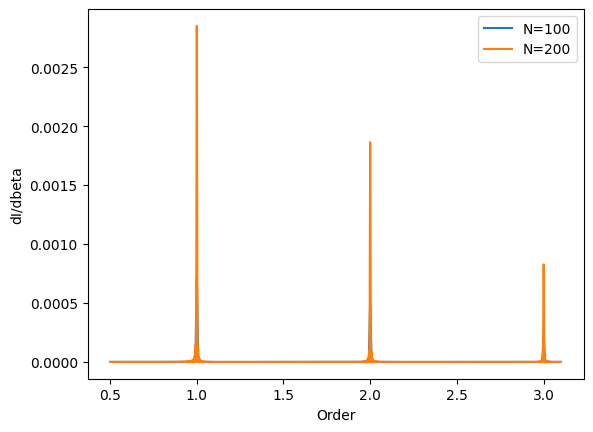

In [46]:
energy = 100
beta = 1e-3
delta = 1e-3
#T_layer = calc_layer([energy],aoi,thickness,[delta], [beta])
a =80
pitch = 100
thickness = 10
x = np.linspace(0.5,3.1,10000)
#x = np.arange(1,11,1)
#T_Grating = calc_box(x,energy,a,pitch,thickness,delta,beta)
T_Grating_2 = sensitivity_box(x,energy,a,pitch,thickness,delta,beta,M=100)#*100*100
T_Grating_10 = sensitivity_box(x,energy,a,pitch,thickness,delta,beta,M=200)#*200*200
#T_Grating_50 = sensitivity_box(x,energy,a,pitch,thickness,delta,beta,M=50)*50*50
#plt.plot(energy,T_layer)
#print(np.sum(T_Grating))
plt.plot(x,T_Grating_2,label='N=100')
plt.plot(x,T_Grating_10,label='N=200')
#plt.plot(x,T_Grating_50,label='N=50')
plt.xlabel('Order')
plt.ylabel('dI/dbeta')
plt.legend()
#plt.yscale('log')
#plt.ylim(1e-10,1e-4)

In [11]:
M = np.arange(500,1000,1)
for entry in M:
    print(np.sin(entry*m*np.pi)/np.sin(m*np.pi))

[           nan -1312.28304419  1312.28304419  -693.40072481
  1312.28304419]
[         nan 471.98989128 471.98989128 471.98989128 471.98989128]
[          nan  368.30326163 -368.30326163 -250.57905775 -368.30326163]
[         nan 648.0505436  648.0505436   29.16822422 648.0505436 ]
[         nan  192.2426093 -192.2426093  192.2426093 -192.2426093]
[          nan  824.11119593  824.11119593 -413.65344283  824.11119593]
[         nan  16.18195698 -16.18195698 635.06427636 -16.18195698]
[          nan 1000.17184826 1000.17184826 1619.05416764 1000.17184826]
[           nan  -159.87869535   159.87869535 -1397.64333411
   159.87869535]
[          nan 1176.23250058 1176.23250058 1176.23250058 1176.23250058]
[          nan -335.93934767  335.93934767 -954.82166705  335.93934767]
[          nan 1352.29315291 1352.29315291  733.41083353 1352.29315291]
[  nan -512.  512. -512.  512.]
[          nan -328.29315291 -328.29315291  290.58916647 -328.29315291]
[          nan -688.06065233  688.060652

/tmp/ipykernel_1658301/2389780181.py:3: RuntimeWarning: invalid value encountered in divide
  print(np.sin(entry*m*np.pi)/np.sin(m*np.pi))


In [8]:

from SALib.sample import sobol as sobol_1
from SALib.analyze import sobol

# Define the model input parameters
problem = {
    'num_vars': 2,  # number of parameters (we are considering beta and one more parameter)
    'names': ['delta', 'beta'],
    'bounds': [
               [-1e-3, 1e-3],
               [0, 1e-3],
               ]  # bounds for beta
}

# Define the model functions
def calc_layer_model(X):
    delta, beta = X
    thickness = 50
    energy = np.array([280])
    delta = np.array([delta])
    beta = np.array([beta])
    return calc_layer(energy, aoi, thickness, delta, beta)


# Generate samples
param_values = sobol_1.sample(problem, 2**6)

# Run the model
Y_layer = np.array([calc_layer_model(X) for X in param_values])

# Perform the Sobol sensitivity  analysis
Si_layer = sobol.analyze(problem, Y_layer)

# Print the first order, second order, and total sensitivity indices
print("Sobol Sensitivity Indices for calc_layer:")
print(Si_layer['S1'])  # First order sensitivity index
print(Si_layer['ST'])  # Total sensitivity index



Sobol Sensitivity Indices for calc_layer:
[2.13866354e-07 1.00233302e+00]
[5.03574319e-11 1.00200447e+00]


/home/kas/Projects/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


In [18]:
#(m,energy,a,d,z,delta,beta,M=1000)

problem = {
    'num_vars': 4,  # number of parameters (we are considering beta and one more parameter)
    'names': ['a','thickness','delta', 'beta'],
    'bounds': [
        [10,80],
        [10,80],
               [-1e-3, 1e-3],
               [0, 1e-3],
               ]  # bounds for beta
}

def calc_box_model(m,a,thickness,delta,beta):
    #a,pitch,thickness,delta,beta = X
    energy =280
    pitch = 100
    #a = 60
    #thickness = 50
    return calc_box(m,energy,a,pitch,thickness,delta,beta,M=10000)
# sample
param_values = sobol_1.sample(problem, 2**9)

# evaluate
m = np.array([0,1,2,3,4,5,6,7])
y = np.array([calc_box_model(m, *params) for params in param_values])

# analyse
sobol_indices = [sobol.analyze(problem, Y) for Y in y.T]

for Si in sobol_indices:
    # Print the first order, second order, and total sensitivity indices
    #print("Sobol Sensitivity Indices for calc_layer:")
    print(Si['S1'])  # First order sensitivity index
    #print(Si['ST'])  # Total sensitivity index


[1.69255216e-01 2.27819493e-01 6.15723654e-05 4.28212434e-01]
[0.09291218 0.33516072 0.14260971 0.16603845]
[0.16401378 0.29155748 0.11661372 0.09529082]
[0.19287179 0.2342826  0.10037027 0.08785292]
[0.24518877 0.24224859 0.08119743 0.07430235]
[0.18585838 0.29997866 0.06859078 0.10418076]
[0.165617   0.29141554 0.10576796 0.07935731]
[0.22887423 0.15271261 0.04642293 0.06890087]


/home/kas/Projects/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


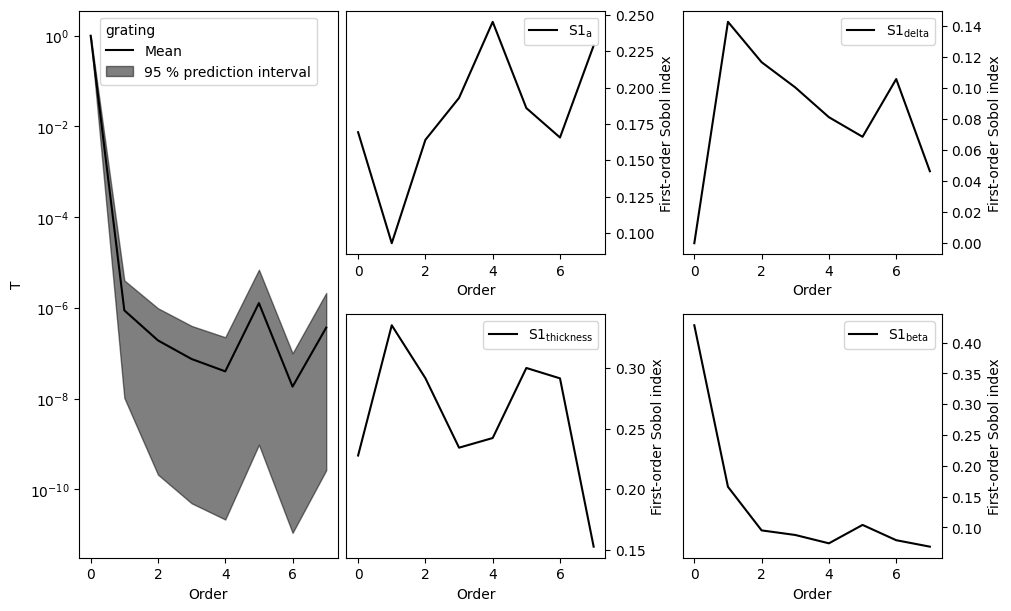

In [19]:
S1s = np.array([s['S1'] for s in sobol_indices])

fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = fig.add_gridspec(2, 3)

ax0 = fig.add_subplot(gs[:, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, 2])

for i, ax in enumerate([ax1, ax2, ax3, ax4]):
    ax.plot(m, S1s[:, i],
            label=r'S1$_\mathregular{{{}}}$'.format(problem["names"][i]),
            color='black')
    ax.set_xlabel("Order")
    ax.set_ylabel("First-order Sobol index")

    #ax.set_ylim(0, 1.04)

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()

    ax.legend(loc='upper right')

ax0.plot(m, np.mean(y, axis=0), label="Mean", color='black')

# in percent
prediction_interval = 95

ax0.fill_between(m,
                 np.percentile(y, 50 - prediction_interval/2., axis=0),
                 np.percentile(y, 50 + prediction_interval/2., axis=0),
                 alpha=0.5, color='black',
                 label=f"{prediction_interval} % prediction interval")

ax0.set_xlabel("Order")
ax0.set_ylabel("T")
ax0.set_yscale('log')
ax0.legend(title=r"grating",
           loc='upper center')._legend_box.align = "left"

plt.show()

In [20]:
import sympy as sp

# Define the variable
beta = sp.symbols('beta')

# Calculate the derivatives
f_prime = sp.diff(calc_layer, beta)
g_prime = sp.diff(calc_box, beta)

# Print the derivatives
print(f"Derivative of f(beta) with respect to beta: {f_prime}")
print(f"Derivative of g(beta) with respect to beta: {g_prime}")

# Evaluate the derivatives at specific beta values
beta_values = [1, 2, 3, 4, 5]  # Example beta values
for value in beta_values:
    f_prime_value = f_prime.evalf(subs={beta: value})
    g_prime_value = g_prime.evalf(subs={beta: value})
    print(f"At beta = {value}, f'({value}) = {f_prime_value}, g'({value}) = {g_prime_value}")

SympifyError: SympifyError: "cannot sympify object of type <class 'function'>"